# Waving Goodbye to Subsequent COVID-19 Waves
### Using data from the Government of Canada on daily cases and daily vaccinations to model the end of the pandemic in Canada

**Disclaimer**: Please note that this project is just for fun and for my personal learning. Although the data is publicly retrievable, these analyses should __not__ be used to guide real-world decisions. Models use an idealized input and are not adequate representations of human behaviour. 

## Part 1. Data Retrieval
The first thing to do is to retrieve data from the Government of Canada websites

In [1]:
# Import dependencies
import cufflinks as cf
import datetime
import missingno as msno
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import urllib

# Display plots inline
%matplotlib inline

In [2]:
# Configure plotly to be offline and notebook_mode to be true
init_notebook_mode(connected=True)

# Configure cufflinks to go offline
cf.go_offline()

In [3]:
# Make a directory to hold the data if it doesn't exist
if not os.path.exists("../data"):
    os.makedirs("../data")

So now we will have to define a function that takes as input a remote URL containing our desired data_source and our output filename.

In [4]:
def download(remote_url: str, local_file: str):
    """Download a file from a remote URL unless the local_file already exists.
    Returns the local_file name."""
    if not os.path.exists(local_file):
        print(f"Retrieving {local_file}...")
        response = urllib.request.urlretrieve(remote_url, local_file)
        return local_file

In [5]:
# Set target datasets to download for our database
# Thankfully, these databases are in .csv format
url_prefix = "https://health-infobase.canada.ca/src/data/covidLive/"
files_list = ['covid19-download.csv', 'covid19-data-dictionary.csv', 'vaccination-coverage-map.csv']

# Get the current time
now = datetime.datetime.utcnow()

# Then download the datasets
for file in files_list:
    if not os.path.exists("../data/" + file):
        download(url_prefix + file, "../data/" + file)
    else:
        # Get the time of modification for the target file
        last_updated = datetime.datetime.utcfromtimestamp(os.path.getctime("../data/" + file))
        
        # If the age of the file is >1 week old,
        # delete the old file and download a new one from the source
        age = now - last_updated

        if age.days > 7:
            print(f"{file} is >1 week old at {age.days} days. Redownloading {file} from source...")
            os.remove("../data/" + file)
            download(url_prefix + file, "../data/" + file)
        else:
            print(f"{file} is <1 week old at {age.days} days.")

covid19-download.csv is <1 week old at 0 days.
covid19-data-dictionary.csv is <1 week old at 0 days.
vaccination-coverage-map.csv is <1 week old at 0 days.


Now that we have our datasets, let's transfer them into a dataframe and see what's inside:

In [6]:
# Read all our data into separate dataframes
data_dict = pd.read_csv('../data/covid19-data-dictionary.csv')
epi_data = pd.read_csv('../data/covid19-download.csv')
vax_data = pd.read_csv('../data/vaccination-coverage-map.csv')

data_dict

,Column Header,Variable Name,Description
0,pruid,Provincial ID,1=Canada \r\n10=Newfoundland and Labrador\r\n1...
1,prname,Province name,Name of P/T (English)
2,prnameFR,Province name,Name of P/T (French)
3,date,Report date,Date reported by P/T
4,numconf,Number of confirmed cases,Number of confirmed cases in each P/T (Canada=...
5,numprob,Number of probable cases,Number of probable cases in each P/T (Canada= ...
6,numdeaths,Number of deaths,Number of deaths in each P/T (Canada= sum of a...
7,numtotal,Total number of cases,Calculated by number of confirmed cases plus n...
8,numtested,Number of individuals tested,"Number of individuals tested in each P/T, as r..."
9,numrecover,Number of recovered cases,Number of recovered cases in each P/T (Canada=...


In [7]:
# Take a look at what's inside one of the dataframes
epi_data.head(10)

,pruid,prname,prnameFR,date,reporting_week,reporting_year,update,totalcases,numtotal_last7,ratecases_total,...,ratecases_last7,ratedeaths_last7,numtotal_last14,numdeaths_last14,ratetotal_last14,ratedeaths_last14,avgcases_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
0,59,British Columbia,Colombie-Britannique,2020-02-01,5,2020,1.0,1,1.0,0.02,...,0.02,0.0,NaN,NaN,NaN,NaN,0.18,0.0,0.0,0.0
1,48,Alberta,Alberta,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
2,47,Saskatchewan,Saskatchewan,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
3,46,Manitoba,Manitoba,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
4,35,Ontario,Ontario,2020-02-01,5,2020,1.0,3,3.0,0.02,...,0.02,0.0,NaN,NaN,NaN,NaN,0.43,0.0,0.0,0.0
5,24,Quebec,Québec,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
6,10,Newfoundland and Labrador,Terre-Neuve-et-Labrador,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
7,13,New Brunswick,Nouveau-Brunswick,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
8,12,Nova Scotia,Nouvelle-Écosse,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0
9,11,Prince Edward Island,Île-du-Prince-Édouard,2020-02-01,5,2020,1.0,0,0.0,0.00,...,0.00,0.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0


It looks like `data_dict` is a dictionary for the column headers for `epi_data`. Let's define them outside here: 

| Column Header | Variable Name | Description | 
| :--- | :--- | :--- |
| **pruid** | Provincial ID | 1=Canada <br> 10=Newfoundland and Labrador <br> 11=Prince Edward Island <br> 12=Nova Scotia <br> 13=New Brunswick <br> 24=Quebec <br> 35=Ontario <br> 46=Manitoba <br> 47=Saskatchewan <br> 48=Alberta <br> 59=British Colombia <br> 60=Yukon <br> 61=Northwest Territories <br> 62=Nunavut <br> 99=Repatriated Travellers |
| **prname** | Province name | Name of P/T (English) |
| **prnameFR** | Province name | Name of P/T (French) |  
| **date** | Report date | Date reported by P/T |
| **numconf** | Number of confirmed cases | Number of confirmed cases in each P/T (Canada= sum of all P/Ts) |
| **numprob** | Number of probable cases | Number of probable cases in each P/T (Canada= sum of all P/Ts) | 
| **numdeaths** | Number of deaths | Number of deaths in each P/T (Canada= sum of all P/Ts) |
| **numtotal** | Total number of cases | Calculated by number of confirmed cases plus number of probable cases (numconf+numprob) |
| **numtested** | Number of individuals tested | Number of individuals tested in each P/T, as reported from the National Microbiology Laboratory |
| **numrecover** | Number of recovered cases | Number of recovered cases in each P/T (Canada=sum of all P/Ts) | 
| **percentrecover** | Percentage of recovered cases | Calculated by the number of recovered cases for a P/T divided by the total number of confirmed cases for that P/T [(numrecover/numtotal) x100] |
| **ratetested** | Testing rate per one million population | Calculated by the number of individuals tested for a P/T divided by the population of that P/T [(numtested/population) x1,000,000] |
| **numtoday** | Number of new cases since last update | Number of total counts from last update subtracted from total counts of current update |
| **percentoday** | Percent change since last update | Calculated by the number of new cases divided by the previous update's total number of cases [(numtoday/numtotal of previous update)x100] |
| **ratetotal** | Case rate per one hundred thousand population | Calculated by the total number of cases for a P/T divided by the population of that P/T[(numtotal/population) x100,000] |

In [8]:
# Describe the rest of the epidemiological data
epi_data.describe()

,pruid,reporting_week,reporting_year,update,totalcases,numtotal_last7,ratecases_total,numdeaths,numdeaths_last7,ratedeaths,ratecases_last7,ratedeaths_last7,numtotal_last14,numdeaths_last14,ratetotal_last14,ratedeaths_last14,avgcases_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
count,2520.000000,2520.000000,2520.000000,2184.000000,2.520000e+03,2395.000000,2352.000000,2520.000000,2376.000000,2352.000000,2227.000000,2208.000000,2380.000000,2368.000000,2213.000000,2201.000000,2395.000000,2227.000000,2376.000000,2208.000000
mean,39.200000,25.577381,2021.196429,0.943223,2.767762e+05,3885.959081,5583.579277,3590.983333,43.628788,45.894588,88.748846,0.655974,7815.817647,87.464527,178.414609,1.312058,555.136539,12.678015,6.232420,0.093610
std,26.288798,15.200720,0.959226,0.231468,7.206537e+05,13423.412154,6691.310910,8335.972308,116.709119,48.826100,198.114774,0.993831,26520.627402,231.895247,390.963388,1.821464,1917.630372,28.300864,16.672752,0.140945
min,1.000000,1.000000,2020.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,12.000000,2020.000000,1.000000,3.157500e+02,5.000000,164.420000,3.000000,0.000000,2.280000,4.100000,0.000000,11.000000,0.000000,8.770000,0.000000,0.710000,0.570000,0.000000,0.000000
50%,46.000000,25.000000,2021.000000,1.000000,1.151100e+04,327.000000,3342.715000,94.000000,3.000000,31.970000,28.520000,0.330000,681.000000,8.000000,58.480000,0.760000,46.650000,4.080000,0.490000,0.050000
75%,60.000000,39.000000,2022.000000,1.000000,1.489112e+05,2545.500000,9877.435000,2386.500000,30.000000,73.080000,82.450000,0.880000,5162.000000,61.250000,168.540000,1.840000,363.645000,11.810000,4.290000,0.130000
max,99.000000,53.000000,2023.000000,1.000000,4.654477e+06,285438.000000,33501.480000,51921.000000,1247.000000,203.870000,2102.840000,11.580000,541978.000000,2363.000000,4085.080000,18.250000,40776.860000,300.320000,178.140000,1.650000


In [9]:
# Describe the vaccination coverage data
vax_data.describe()

,pruid,numtotal_atleast1dose,numtotal_partially,numtotal_fully,numtotal_onlyfully,numtotal_additional,numtotal_1additional,numtotal_2nd_additional,numtotal_recent_fullyoradditional,proptotal_atleast1dose,...,num12plus_1additional,num12plus_2nd_additional,num12plus_recent_fullyoradditional,prop12plus_partially,prop12plus_fully,prop12plus_onlyfully,prop12plus_additional,prop12plus_1additional,prop12plus_2nd_additional,prop12plus_recent_fullyoradditional
count,1155.000000,1.155000e+03,1.146000e+03,1.132000e+03,4.210000e+02,4.210000e+02,4.210000e+02,1.750000e+02,1.240000e+02,1155.000000,...,4.210000e+02,1.750000e+02,1.240000e+02,817.000000,817.000000,421.000000,421.000000,421.000000,175.000000,124.000000
mean,34.956710,3.324426e+06,5.730183e+05,2.722352e+06,1.918312e+06,2.409438e+06,2.040778e+06,8.868903e+05,1.159643e+06,61.385887,...,2.034353e+06,8.866415e+05,1.114820e+06,8.332313,78.767687,38.483848,48.598575,41.563420,16.968571,20.154032
std,21.648721,7.000999e+06,1.820560e+06,6.231153e+06,3.470333e+06,4.544567e+06,3.877032e+06,1.822143e+06,2.137142e+06,29.808175,...,3.869234e+06,1.821550e+06,2.055587e+06,12.216591,18.240815,10.702733,11.199866,11.093883,9.108067,6.247411
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.377500e+04,5.705000e+03,5.705000e+03,0.000000e+00,2.313000e+03,0.000000,...,5.632000e+03,0.000000e+00,1.775000e+03,1.500000,3.100000,5.400000,8.500000,8.500000,0.000000,5.800000
25%,12.000000,3.503700e+04,6.504000e+03,2.960250e+04,6.184700e+04,7.755400e+04,5.409400e+04,1.162200e+04,3.637200e+04,46.750000,...,5.367100e+04,1.161700e+04,3.422150e+04,2.900000,77.500000,33.500000,45.800000,33.500000,9.300000,16.575000
50%,46.000000,6.139710e+05,5.515050e+04,3.932220e+05,4.087820e+05,4.975150e+05,3.871820e+05,1.567170e+05,2.136550e+05,75.800000,...,3.871370e+05,1.567170e+05,2.016745e+05,3.800000,85.600000,36.300000,51.300000,43.600000,16.700000,20.650000
75%,59.000000,3.382160e+06,3.153480e+05,1.112650e+06,1.773691e+06,2.515683e+06,1.979642e+06,8.352415e+05,1.539489e+06,82.300000,...,1.979502e+06,8.350915e+05,1.472703e+06,7.500000,88.100000,40.300000,55.700000,49.700000,25.800000,23.975000
max,62.000000,3.252141e+07,1.996107e+07,3.133777e+07,1.618017e+07,1.981768e+07,1.834491e+07,9.567163e+06,9.714690e+06,96.100000,...,1.834374e+07,9.561062e+06,9.346083e+06,68.400000,96.900000,80.700000,65.200000,61.700000,35.800000,36.300000


Let's take a look at all the missing data in our dataframes.

<AxesSubplot: >

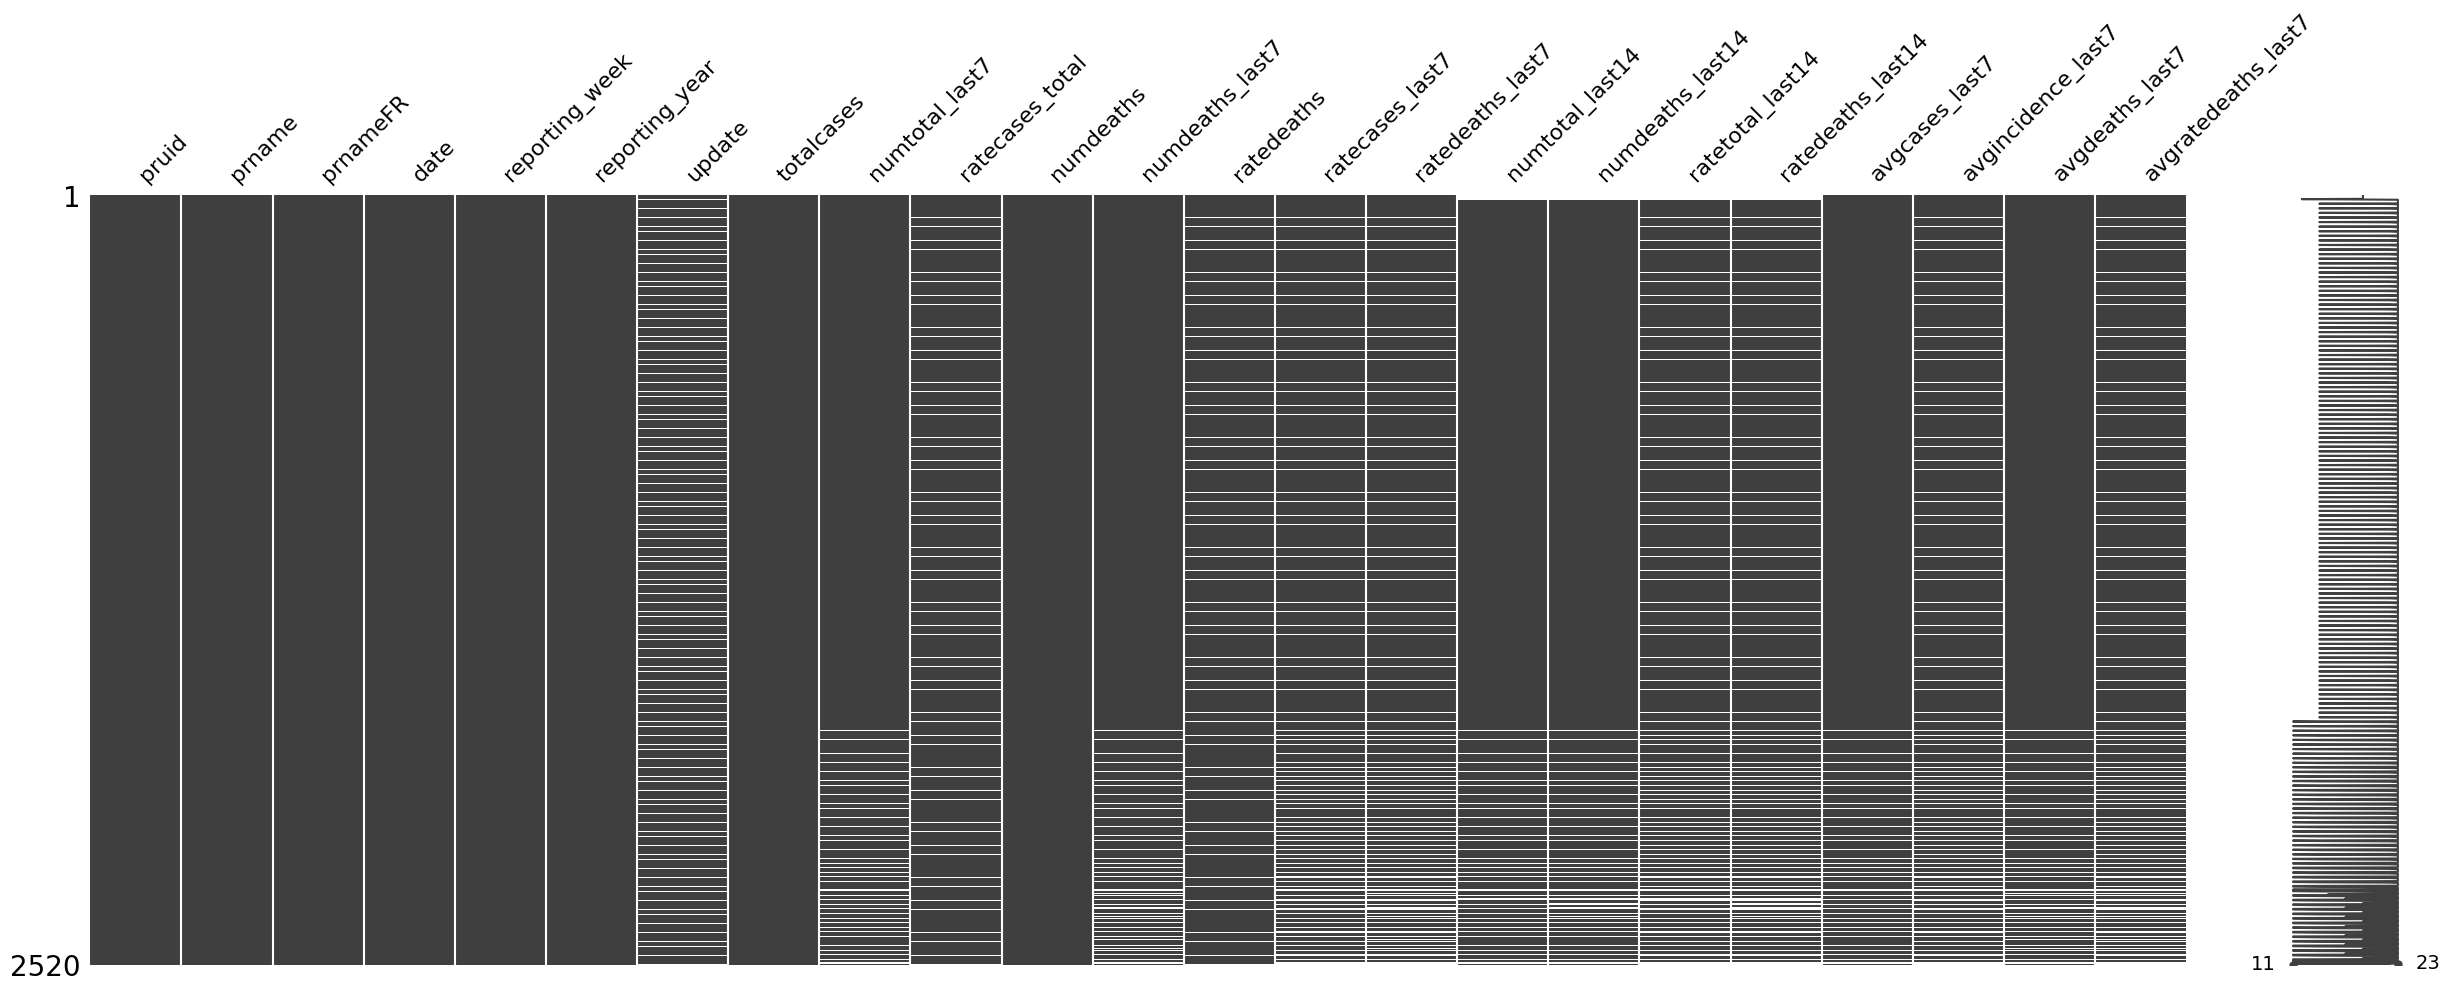

In [10]:
# Plot graphic of missing data for epi_data
msno.matrix(epi_data, figsize=(30, 10))

<AxesSubplot: >

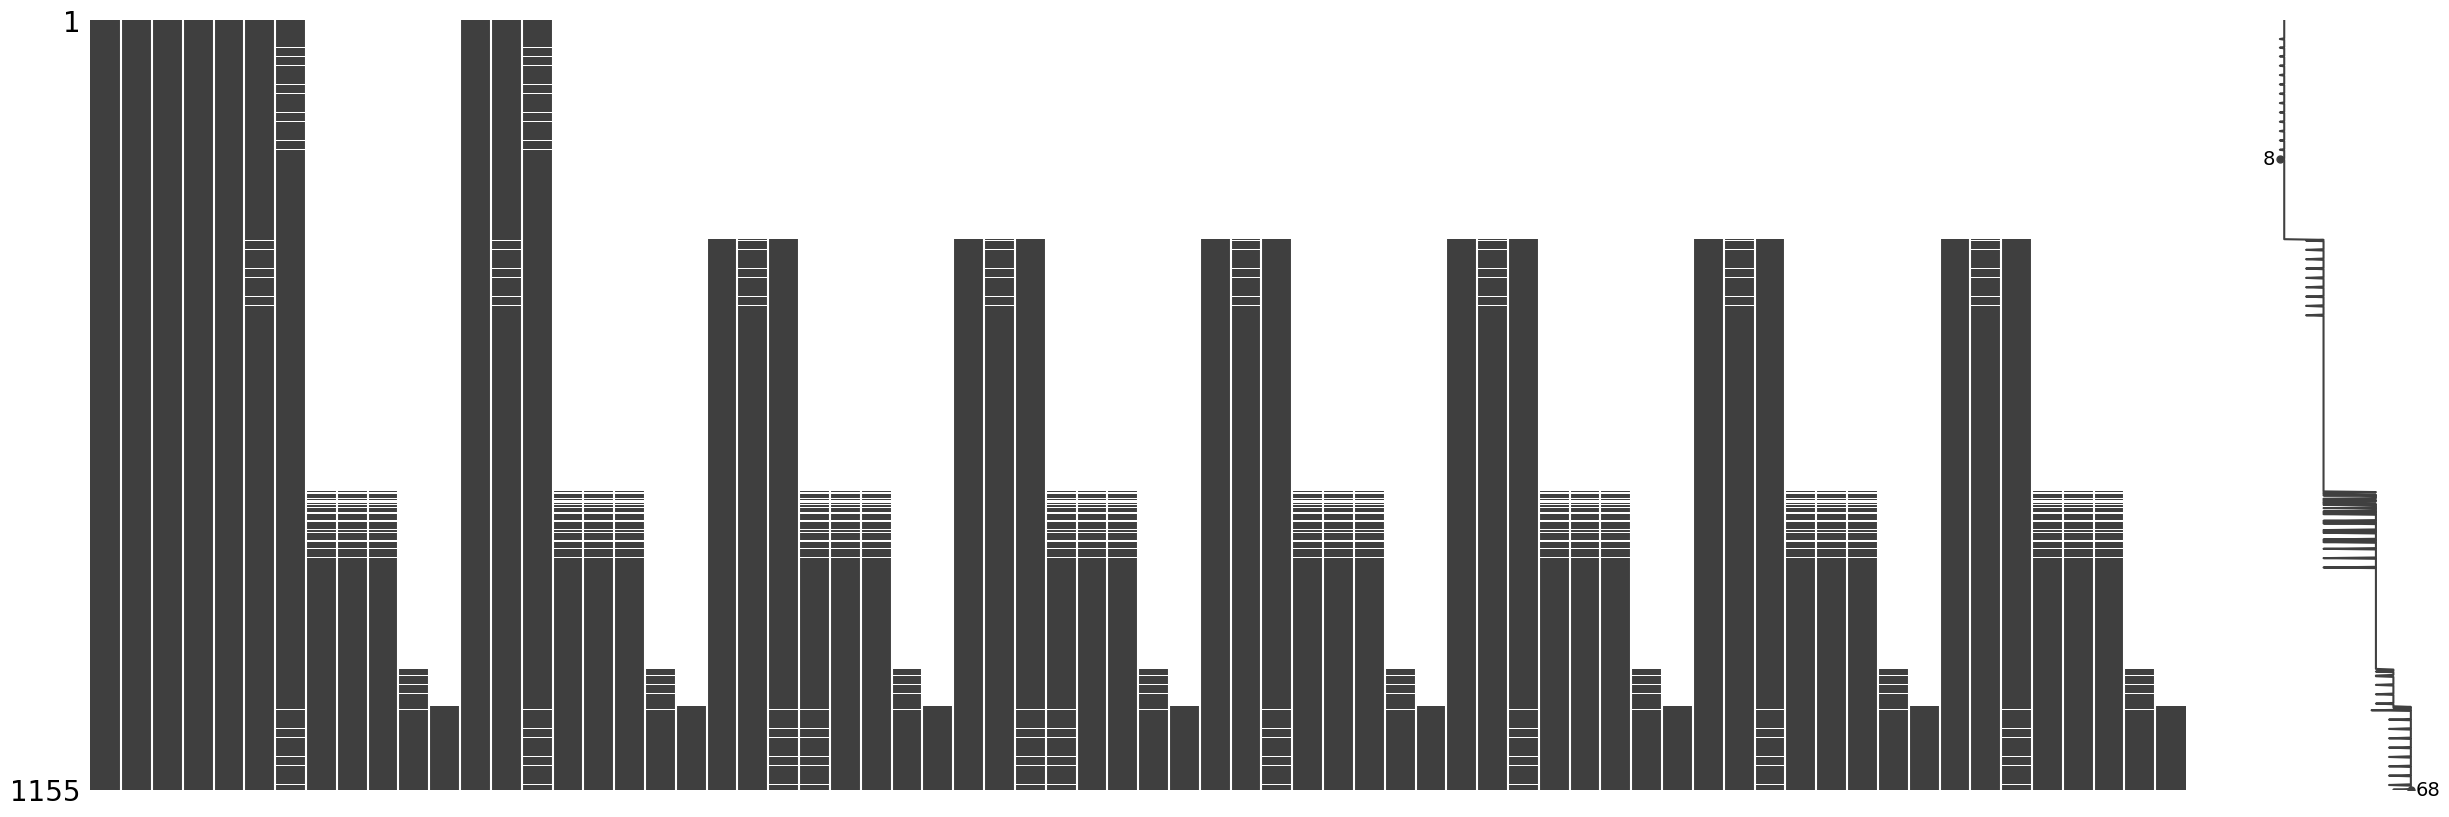

In [11]:
# Plot graphic for missing data for vax_data
msno.matrix(vax_data, figsize=(30, 10))

In [12]:
# Extract provincial IDs into a list
pruid = sorted(epi_data["pruid"].unique())

# Generate a dictionary that sets the provincial ID as key and province name as value
provinces = dict()

for id in pruid:
    provinces[id] = epi_data[epi_data["pruid"] == id]["prname"].unique()[0]

print(provinces)

{1: 'Canada', 10: 'Newfoundland and Labrador', 11: 'Prince Edward Island', 12: 'Nova Scotia', 13: 'New Brunswick', 24: 'Quebec', 35: 'Ontario', 46: 'Manitoba', 47: 'Saskatchewan', 48: 'Alberta', 59: 'British Columbia', 60: 'Yukon', 61: 'Northwest Territories', 62: 'Nunavut', 99: 'Repatriated travellers'}


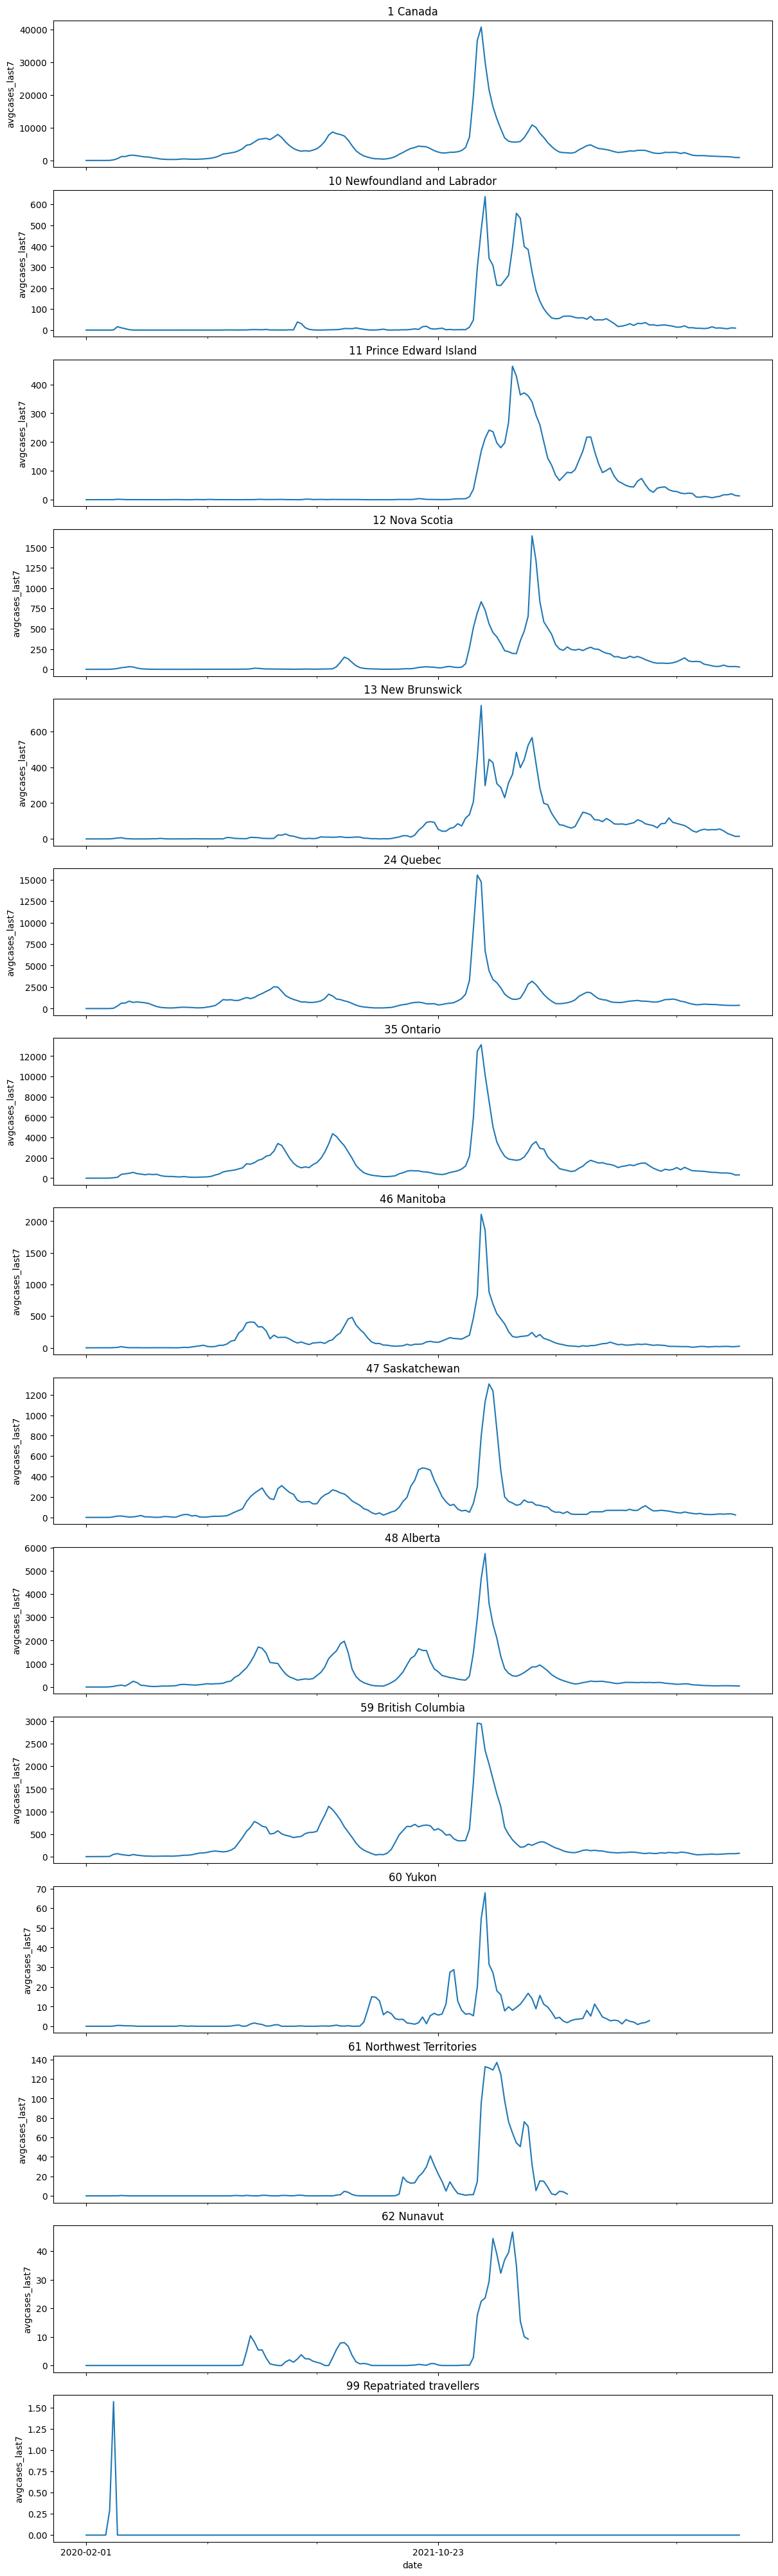

In [13]:
# Generate a subplot structure to display graphs
fig, ax = plt.subplots(nrows=len(provinces), ncols=1, figsize=(12, 40), sharex=True, constrained_layout=True)

# For each subplot, generate a plot of numtoday cases by date
for i, id in enumerate(pruid):
    # Select the data by province and generate a lineplot 
    sns.lineplot(ax=ax[i], data=epi_data[epi_data["pruid"] == id], x="date", y="avgcases_last7")
    ax[i].set_title(f"{id} {provinces[id]}")
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator())

Using plotly we can make these plots interactive!

In [14]:
# Make a title list for subplot_titles argument
province_title = [(f"{id} {provinces[id]}") for id in pruid]

# Use plotly's subplot maker to generate subplots
fig = sp.make_subplots(rows = len(provinces), cols = 1, subplot_titles=province_title)

# # For each subplot, generate a plot of numtoday cases by date
for i, id in enumerate(pruid):
    # Select the data by province and generate a lineplot using plotly's graph_objects as go
    fig.add_trace(go.Scatter(x=epi_data[epi_data["pruid"] == id]["date"], y=epi_data[epi_data["pruid"] == id]["avgcases_last7"]), col=1, row=i+1)

# Update layout to fit all graphs
fig.update_layout(height=3200, width=800)
iplot(fig)